# GOOGLE get files

!apt-get install gcsfuse -y

# create directory
!mkdir uh-segmentation-training-mount

# mount bucket on directory
!gcsfuse --implicit-dirs uh-segmentation-training uh-segmentation-training-mount

# GOOGLE see files

!ls uh-segmentation-training-mount/data/train_images

# GOOGLE install

!pip install --upgrade pip

!pip install tensorflow[and-cuda]

!pip install pydicom
!pip install keras
!pip install numpy
!pip install matplotlib
!pip install opencv-python

In [1]:
# imports

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Conv2DTranspose,
    concatenate, BatchNormalization, Activation
)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pydicom

# GOOGLE gpu check

tf.config.list_physical_devices('GPU')

In [2]:
# target file system

# data/
# ———> train/
# ———> validate/
# ———> test/
# models/
# outputs/

In [3]:
# config

SOURCE_DIR = "data/play" # does not work without a source
TARGET_DIR = ""
COPY_DATA_TO_TARGET = False # make copies of data?

MODEL_DIR = "models"
MODEL = "multiclass_test.keras" # always .keras

TRAIN_IMGS = "data/train" 
TRAIN_MSKS = "data/train"
VAL_IMGS = "data/validate"
VAL_MSKS = "data/validate"
TEST_IMGS = "data/test"
TEST_MSKS = "data/test"
# OUTPUT_DIR = "outputs"

R_TRAIN = 0.8
R_VAL = 0.2
# R_TEST = 0.0

IMG_WIDTH = 256 # this may need to be higher depending on dicom images
IMG_HEIGHT = 256
IMG_CHANNELS = 1
N_CLASSES = 6 # the types of surgical instruments we're looking for
BATCH_SIZE = 16 # default=16, could be higher if running on cloud
BUFFER_SIZE = 100 # depends on training set size

STEP = 1e-2 # learning rate, default=1e-4
EPOCHS = 2 # does fewer data mean fewer epochs? default=5? 25?
LAYERS = 4 # default=4

In [4]:
# create directories

if not TARGET_DIR:
    TARGET_DIR = os.getcwd()
os.makedirs(os.path.join(TARGET_DIR, TRAIN_IMGS), exist_ok=True)
os.makedirs(os.path.join(TARGET_DIR, TRAIN_MSKS), exist_ok=True)
os.makedirs(os.path.join(TARGET_DIR, VAL_IMGS), exist_ok=True)
os.makedirs(os.path.join(TARGET_DIR, VAL_MSKS), exist_ok=True)
os.makedirs(os.path.join(TARGET_DIR, TEST_IMGS), exist_ok=True)
os.makedirs(os.path.join(TARGET_DIR, TEST_MSKS), exist_ok=True)
os.makedirs(os.path.join(TARGET_DIR, MODEL_DIR), exist_ok=True)

In [5]:
# train test split

try:

    img_fs = [f for f in os.listdir(SOURCE_DIR) if f.endswith('.dcm')]
    msk_fs = [f for f in os.listdir(SOURCE_DIR) if f.endswith('.npy')]

    if len(img_fs) != len(msk_fs):
        class UnequalImageMaskError(Exception): pass
        raise UnequalImageMaskError("image and mask list lengths are not equal")
    else:
        msk_fs_ragged = [[f] for f in msk_fs]
except UnequalImageMaskError as uime:
    print(uime)
    print("checking for multiple masks")

    msk_fs_ragged = list()
    for f in img_fs:
        fname = f.removesuffix('.dcm') # apply more transforms if needed
        corr_masknames = [fm for fm in msk_fs if fname.strip() in fm]
        if len(corr_masknames) < 1:
            raise UnequalImageMaskError(f"image {f} has no corresponding mask")
        msk_fs_ragged.append(corr_masknames)

except Exception as e:
    print("there probably isn't a source directory")
    print()
    print(e)

if SOURCE_DIR:
    seed = 42
    labels = None # we do have classes
    train_img_fs, val_img_fs = train_test_split(
        sorted(img_fs), 
        train_size=R_TRAIN, test_size=R_VAL, 
        random_state=seed,
        stratify=labels
    )
    train_msk_fs, val_msk_fs = train_test_split(
        sorted(msk_fs_ragged, key=lambda x: x[0]), 
        train_size=R_TRAIN, test_size=R_VAL, 
        random_state=seed,
        stratify=labels
    )

    if (len(train_img_fs) != len(train_msk_fs)) or (len(val_img_fs) != len(val_msk_fs)):
        class UnequalImageMaskError(Exception): pass
        raise UnequalImageMaskError("image and mask list lengths are **still** not equal")
    

if SOURCE_DIR and COPY_DATA_TO_TARGET:
    for f in train_img_fs: shutil.copy2(
        os.path.join(SOURCE_DIR, f),
        os.path.join(TARGET_DIR, TRAIN_IMGS, f)
    )
    for f in val_img_fs: shutil.copy2(
        os.path.join(SOURCE_DIR, f),
        os.path.join(TARGET_DIR, VAL_IMGS, f)
    )
    for fs in train_msk_fs: 
        for f in fs: shutil.copy2(
        os.path.join(SOURCE_DIR, f),
        os.path.join(TARGET_DIR, TRAIN_MSKS, f)
    )
    for fs in val_msk_fs: 
        for f in fs: shutil.copy2(
        os.path.join(SOURCE_DIR, f),
        os.path.join(TARGET_DIR, VAL_MSKS, f)
    )

image and mask list lengths are not equal
checking for multiple masks


In [6]:
# FUNC load an image

def _load_dicom_and_numpy(image_path, mask_paths):
    image_path = image_path.numpy().decode('utf-8')
    mask_paths = [mask_path.numpy().decode('utf-8') for mask_path in mask_paths]

    # image
    ds = pydicom.dcmread(image_path)
    img = ds.pixel_array.astype(np.float32)

    # standardize channels
    if img.ndim == 2:
        img = np.expand_dims(img, axis=-1)
    n_channels = img.shape[2]
    if n_channels == IMG_CHANNELS: # if correct, do nothing
        pass
    elif n_channels == 1: # multiply
        img = np.tile(img, (1, 1, IMG_CHANNELS))
    elif n_channels == 3: # reduce to 1 then multiply
        img = np.mean(img, axis=-1, keepdims=True)
        img = np.tile(img, (1, 1, IMG_CHANNELS))
    elif n_channels < IMG_CHANNELS: # add padding
        padding = np.zeros(img.shape[:2] + (IMG_CHANNELS-n_channels,), dtype=img.dtype) 
        img = np.concatenate([img, padding], axis=-1)
    elif n_channels > IMG_CHANNELS: # slice down
        img = img[..., :IMG_CHANNELS] 

    # normalize image
    if "RescaleSlope" in ds and "RescaleIntercept" in ds:
        img = img * ds.RescaleSlope + ds.RescaleIntercept
    min_val, max_val = np.min(img), np.max(img)
    if max_val - min_val > 1e-6: 
        img = (img - min_val) / (max_val - min_val)
    else:
        img = img - min_val

    # mask
    masks = list()
    for mask_path in mask_paths:
        mask = np.load(mask_path).astype(np.float32)
        mask = np.clip(mask / 255.0, 0.0, 1.0) # ensure mask is binary
        mask = tf.image.resize_with_pad(mask[..., tf.newaxis], IMG_HEIGHT, IMG_WIDTH).numpy()
        # mask = np.expand_dims(mask, axis=-1) # add channel dim
        masks.append(mask)
    
    stack = np.squeeze(np.stack(masks, axis=-1), axis=2) # stack masks
    n_pad = N_CLASSES - stack.shape[-1]
    padding = np.zeros((stack.shape[0], stack.shape[1], n_pad), dtype=np.float32)

    mask_tensor = np.concatenate([stack, padding], axis=-1) # H, W, N_CLASSES

    return img, mask_tensor

def load_and_preprocess(image_path, mask_paths):
    img, mask = tf.py_function( # wrapper for _load_dicom_and_numpy
        _load_dicom_and_numpy,
        [image_path, mask_paths],
        [tf.float32, tf.float32]
    )
    
    img.set_shape([None, None, IMG_CHANNELS])
    img = tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH)
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])

    mask.set_shape([None, None, N_CLASSES])
    mask = tf.image.resize_with_pad(mask, IMG_HEIGHT, IMG_WIDTH, method='nearest')
    mask.set_shape([IMG_HEIGHT, IMG_WIDTH, N_CLASSES])
    
    return img, mask

In [7]:
# FUNC augment image

def augment_data(img, mask):
    if tf.random.uniform(()) > 0.5: # randomly flip image
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32) # randomly rotate 90*
    img = tf.image.rot90(img, k=k)
    mask = tf.image.rot90(mask, k=k)
    return img, mask

In [8]:
# training pipeline

train_image_paths = sorted([os.path.join(SOURCE_DIR, f) for f in train_img_fs if f.endswith('.dcm')]) # sorted([os.path.join(SOURCE_DIR, f) for f in os.listdir(SOURCE_DIR) if f.endswith(".dcm") and f in train_img_fs])
train_mask_paths = sorted([[os.path.join(SOURCE_DIR, f) for f in fs if f.endswith('.npy')] for fs in train_msk_fs], key=lambda x: x[0]) # sorted([os.path.join(SOURCE_DIR, f) for f in os.listdir(SOURCE_DIR) if f.endswith(".npy") and f in train_msk_fs])

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, tf.ragged.constant(train_mask_paths)))
train_dataset = train_dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.cache() # optional
train_dataset = train_dataset.shuffle(BUFFER_SIZE) # unsure how much data you have, hence buffer and batch
train_dataset = train_dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
# validation pipeline

val_image_paths = sorted([os.path.join(SOURCE_DIR, f) for f in val_img_fs if f.endswith('.dcm')]) # sorted([os.path.join(SOURCE_DIR, f) for f in os.listdir(SOURCE_DIR) if f.endswith(".dcm") and f in val_img_fs])
val_mask_paths = sorted([[os.path.join(SOURCE_DIR, f) for f in fs if f.endswith('.npy')] for fs in val_msk_fs], key=lambda x: x[0]) # sorted([os.path.join(SOURCE_DIR, f) for f in os.listdir(SOURCE_DIR) if f.endswith(".npy") and f in val_msk_fs])

val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, tf.ragged.constant(val_mask_paths)))
val_dataset = val_dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

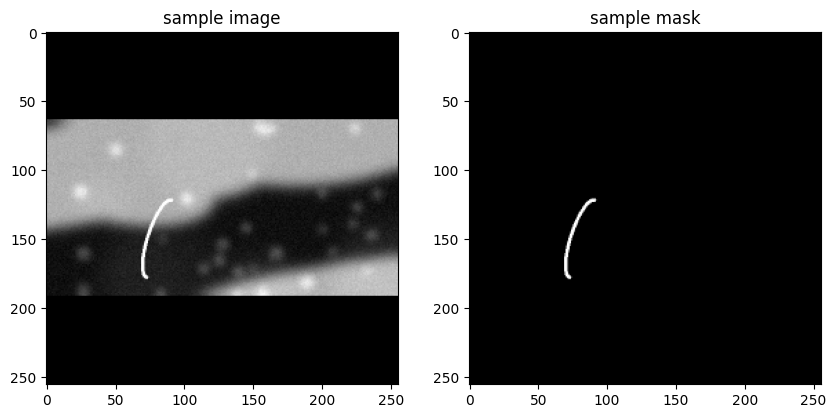

In [10]:
# display sample image

for images, masks in train_dataset.take(1):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("sample image")
    plt.imshow(images[0, :, :, 0], cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title("sample mask")
    plt.imshow(masks[0, :, :, 0], cmap='gray')

    # plt.savefig(f"view_{1}")
    plt.show()

In [11]:
# define model

def encoder(inputs, num_filters): # encoder block
    c = Conv2D(num_filters, 3, activation='relu', padding='same')(inputs) 
    c = BatchNormalization()(c)
    c = Conv2D(num_filters, 3, activation='relu', padding='same')(c)
    p = MaxPooling2D(pool_size=(2, 2))(c)
    return c, p

def bottleneck(inputs, num_filters): # final convolution before decoder
    b = Conv2D(num_filters, 3, activation='relu', padding='same')(inputs)
    b = BatchNormalization()(b)
    b = Conv2D(num_filters, 3, activation='relu', padding='same', name="final_convolution_before_decoder")(b)
    return b

def decoder(inputs, skip_connection, num_filters): # decoder block
    d = Conv2DTranspose(num_filters, 2, strides=2, padding='same')(inputs)
    d = concatenate([d, skip_connection])
    d = Conv2D(num_filters, 3, activation='relu', padding='same')(d)
    d = BatchNormalization()(d)
    d = Conv2D(num_filters, 3, activation='relu', padding='same')(d)
    return d

c = {}
p = {0: Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))}

for layer in range(1, 1 + LAYERS): c[layer], p[layer] = encoder(p[layer-1], 2**(5+layer))

d = {0: bottleneck(p[LAYERS], 2**(6+LAYERS))}

for layer in range(LAYERS): d[layer+1] = decoder(d[layer], c[LAYERS-layer], 2**(5+LAYERS-layer))

model = Model(
    inputs=p[0], 
    outputs=Conv2D(N_CLASSES, 1, padding='same', activation ='softmax', name='output_mask')(d[LAYERS]), 
    name="UNET"
)
model.summary()

Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      2,048 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ batch_normalizat… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 31,042,694 (118.42 MB)

 Trainable params: 31,036,806 (118.40 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [12]:
# model look

# inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# c1, p1 = encoder(inputs, 64)
# c2, p2 = encoder(p1, 128)
# c3, p3 = encoder(p2, 256)
# c4, p4 = encoder(p3, 512)

# b1 = bottleneck(p4, 1024)

# d1 = decoder(b1, c4, 512)
# d2 = decoder(d1, c3, 256)
# d3 = decoder(d2, c2, 128)
# d4 = decoder(d3, c1, 64)

# outputs = Conv2D(1, 1, padding='same', activation ='sigmoid', name='output_mask')(d4)
# d = Model(inputs=inputs, outputs=outputs, name="UNET")
# model.summary()

In [13]:
# FUNC loss

# consider focal loss
# dice loss commonly used for segmentation to reduce overlap / account for small foreground object
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

def categorical_crossentropy(y_true, y_pred, smooth=1e-6):
    y_pred = K.clip(y_pred, smooth, 1-smooth)
    xentropy = y_true * K.log(y_pred)
    xentropy = -K.sum(xentropy, axis=-1)
    return K.mean(xentropy)

def categorical_dice_loss(y_true, y_pred, smooth=1e-6):
    intersection = K.sum(y_true * y_pred, axis=[1, 2])
    union = K.sum(y_true, axis=[1, 2]) + K.sum(y_pred, axis=[1, 2])
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - K.mean(dice)

def dice_xentropy_hybrid(y_true, y_pred, w_dice=0.5, w_xentropy=0.5):
    dice = categorical_dice_loss(y_true, y_pred)
    xentropy = categorical_crossentropy(y_true, y_pred)
    return (dice * w_dice) + (xentropy * w_xentropy)

In [14]:
# compile model

# Adam is default, consider stochastic gradient descent for more control over learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=STEP),
    loss=dice_xentropy_hybrid,
    metrics=['accuracy']
)

In [15]:
# train model

history = model.fit(
    train_dataset, # .take(2)
    validation_data=val_dataset,
    epochs=EPOCHS,
)
model.save(os.path.join(TARGET_DIR, MODEL_DIR, MODEL))

Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.0086 - loss: 0.5000 - val_accuracy: 0.9987 - val_loss: 0.5000
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.2841 - loss: 0.5000 - val_accuracy: 0.9987 - val_loss: 0.5000


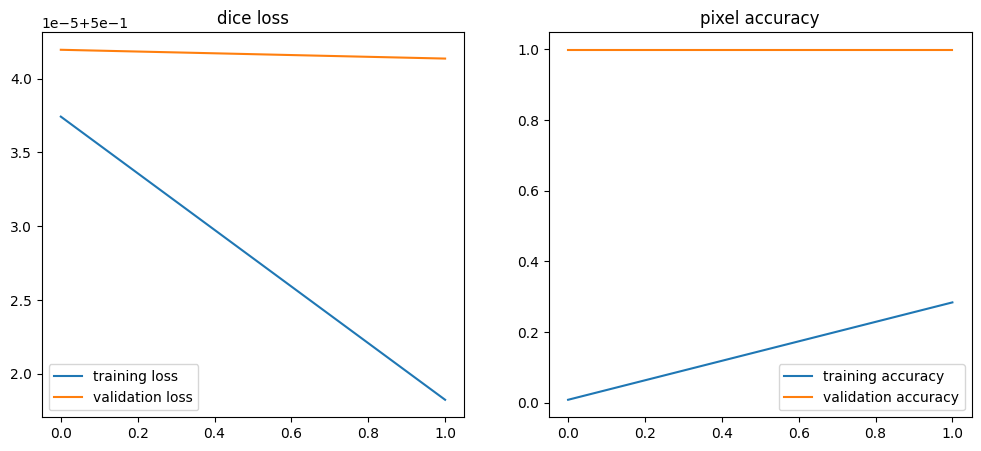

In [16]:
# see training

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="training loss")
if 'val_loss' in history.history: 
    plt.plot(history.history['val_loss'], label="validation loss")
plt.title("dice loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="training accuracy")
if 'val_accuracy' in history.history: 
    plt.plot(history.history['val_accuracy'], label="validation accuracy")
plt.title("pixel accuracy")
plt.legend()

# plt.savefig("history")
plt.show()

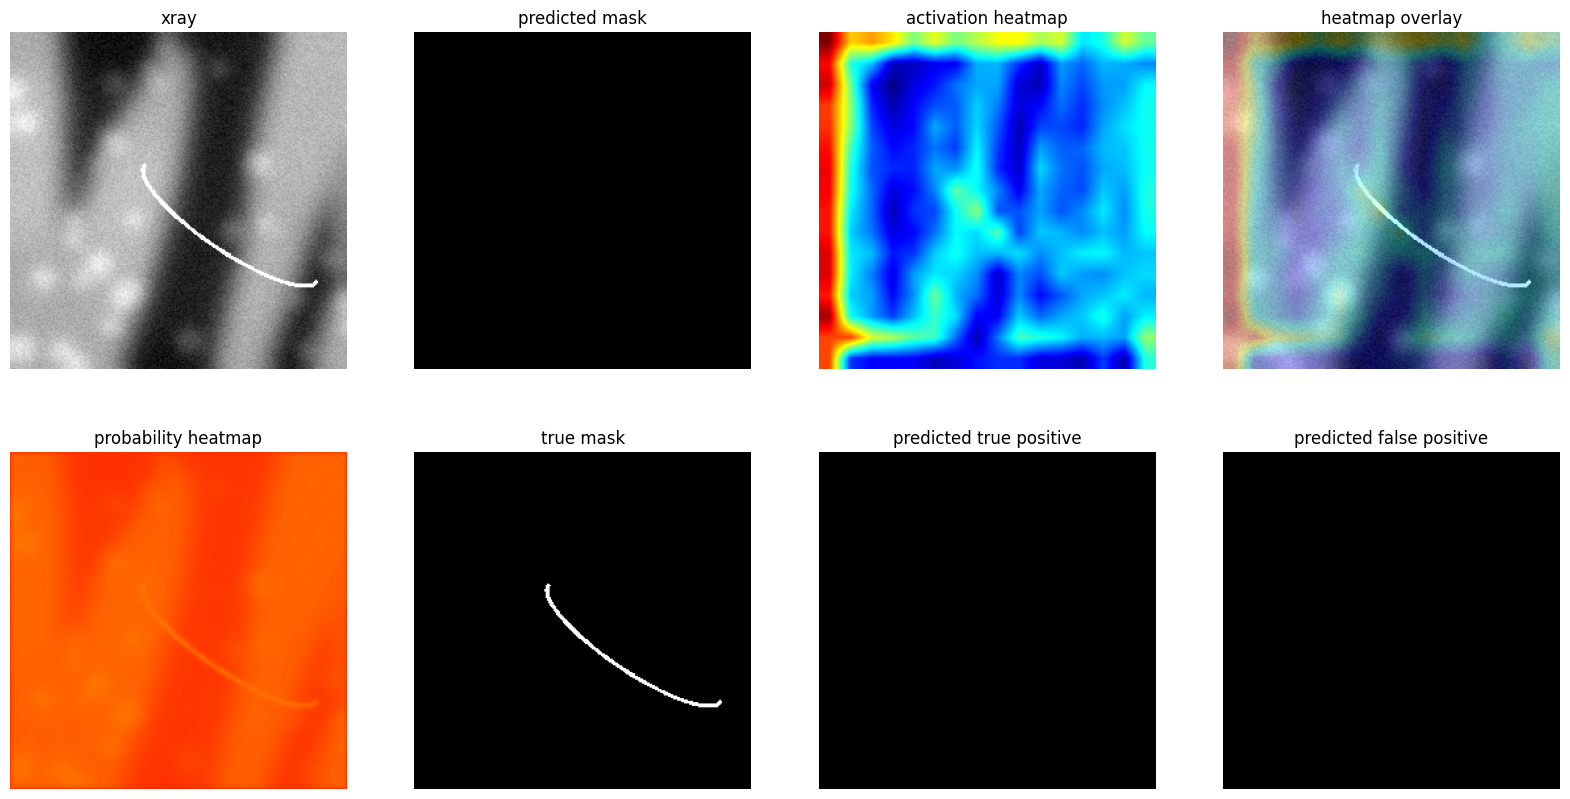

In [18]:
# make prediction

# load trained model
trained_model = keras.models.load_model( 
    os.path.join(TARGET_DIR, MODEL_DIR, MODEL),
    custom_objects={"dice_xentropy_hybrid": dice_xentropy_hybrid}
)

# load and preprocess single image
TEST_IMAGE = os.path.join(TARGET_DIR, TEST_IMGS, "image_0000.dcm")
TEST_MASKS = [
    os.path.join(TARGET_DIR, TEST_MSKS, "image_0000_mask.npy"),
]

ds = pydicom.dcmread(TEST_IMAGE)
img = ds.pixel_array.astype(np.float32)
img = np.expand_dims(img, axis=-1)

img_tensor = tf.convert_to_tensor(img)
img_resized = tf.image.resize_with_pad(img_tensor, IMG_HEIGHT, IMG_WIDTH)
if "RescaleSlope" in ds and "RescaleIntercept" in ds:
    img_resized = img_resized * ds.RescaleSlope + ds.RescaleIntercept
min_val, max_val = np.min(img_resized), np.max(img_resized)
if max_val - min_val > 1e-6: 
    img_normalized = (img_resized - min_val) / (max_val - min_val)
else:
    img_normalized = img_resized - min_val
img_batch = tf.expand_dims(img_normalized, axis=0) # batch of 1

# generate gradient heatmap
bottleneck = "final_convolution_before_decoder"

grad_model = Model(
    trained_model.inputs,
    [trained_model.get_layer(bottleneck).output, trained_model.output]
)

with tf.GradientTape() as tape: # calculate gradients
    bottleneck_output, model_output = grad_model(img_batch)
    # choose max probability across all masks per pixel
    rep_model_output = tf.reduce_max(model_output, axis=-1)
    # "class score" is mean of output mask
    class_score = tf.reduce_mean(rep_model_output)

grads = tape.gradient(class_score, bottleneck_output) # get gradient wrt conv layer
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)) # get weights

bottleneck_output = bottleneck_output[0]
heatmap = bottleneck_output @ pooled_grads[..., tf.newaxis] # multiply by weights
heatmap = tf.squeeze(heatmap)

heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

# get mask prediction
unprocessed_pred_mask = np.max(model_output[0].numpy(), axis=-1)
unprocessed_pred_mask_color = np.uint8(255 * unprocessed_pred_mask)
unprocessed_pred_mask_color = cv2.applyColorMap(unprocessed_pred_mask_color, cv2.COLORMAP_JET)
pred_mask = (unprocessed_pred_mask > 0.5).astype(np.uint8)

# create overlay
img_overlay = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
overlay = cv2.cvtColor(img_overlay.astype(np.uint8), cv2.COLOR_GRAY2RGB)
overlay_resized = cv2.resize(overlay, (IMG_WIDTH, IMG_HEIGHT))
heatmap_resized = cv2.resize(heatmap, (IMG_WIDTH, IMG_HEIGHT))
heatmap_color = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_color, cv2.COLORMAP_JET)

heatmap_overlay = cv2.addWeighted(overlay_resized, 0.7, heatmap_color, 0.3, 0)

# find test mask
test_mask = None
if TEST_MASKS and np.all([os.path.exists(f) for f in TEST_MASKS]):
    fmasks = list()
    for f in TEST_MASKS:
        fmask = np.load(f).astype(np.float32)
        fmask = np.clip(fmask / 255.0, 0.0, 1.0)
        fmasks.append(fmask)

if fmasks:
    test_mask = np.stack(fmasks, axis=-1)
    test_mask = np.max(test_mask, axis=-1)
    test_mask = np.expand_dims(test_mask, axis=-1)

# find error between true mask and predicted mask
    test_mask_resized = cv2.resize(test_mask, (IMG_HEIGHT, IMG_WIDTH))
    test_mask_binary = (test_mask_resized > 0.5).astype(np.uint8)
    # test_mask_resized = cv2.normalize(test_mask_resized, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # test_mask_resized = np.expand_dims(test_mask_resized.astype(np.uint8), axis=-1)

    true_positive_mask = test_mask_binary & pred_mask
    # true_positive_mask = cv2.addWeighted(test_mask_resized, 0.5, pred_mask, 0.5, 0)
    false_positive_mask = (test_mask_binary == 0) & pred_mask

# display
plt.figure(figsize=(20, 10))

plt.subplot(2, 4, 1) # og
plt.title("xray") 
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(2, 4, 2) # prediction mask
plt.title("predicted mask")
plt.imshow(pred_mask, cmap='gray')
plt.axis('off')

plt.subplot(2, 4, 3) # heatmap
plt.title("activation heatmap")
plt.imshow(heatmap_color)
plt.axis('off')

plt.subplot(2, 4, 4)
plt.title("heatmap overlay") # heatmap overlayed on image
plt.imshow(heatmap_overlay) 
plt.axis('off')

plt.subplot(2, 4, 5) # heatmap
plt.title("probability heatmap")
plt.imshow(unprocessed_pred_mask_color)
plt.axis('off')

if test_mask is not None:
    plt.subplot(2, 4, 6)
    plt.title("true mask") # actual mask
    plt.imshow(test_mask, cmap='gray') 
    plt.axis('off')

    plt.subplot(2, 4, 7)
    plt.title("predicted true positive") # predicted mask vs actual mask, correct pixels
    plt.imshow(true_positive_mask, cmap='gray') 
    plt.axis('off')

    plt.subplot(2, 4, 8)
    plt.title("predicted false positive") # predicted mask vs actual mask, mistakenly activated pixels
    plt.imshow(false_positive_mask, cmap='gray') 
    plt.axis('off')

# plt.savefig("test")
plt.show()